## Predicting House Price

### Introduction and Motivation

### Import Libraries

In [51]:
# Data manipulation and numerical operations
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import kruskal

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning models
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Preprocessing and feature engineering
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Feature-engine for winsorization (from the feature-engine library)
from feature_engine.outliers import Winsorizer

# Model evaluation and cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Mean Squared Error metric scorer
from sklearn.metrics import make_scorer

### Data Loading

In [21]:
# read csv file
file_path = "train.csv"
train_data = pd.read_csv(file_path)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Data Preprocessing

#### A. Identify Missing Values

In [22]:
# create function to generate missing values
def miss_val_table(data):
    # show number of missing values for the columns
    missing_counts = pd.DataFrame(data.isnull().sum())

    # change column name
    missing_counts = missing_counts.rename(columns={0:"total_missing"})
    # filter
    filter_counts = missing_counts['total_missing'] != 0

    # final table
    final_missing_counts = missing_counts[filter_counts].copy()
    final_missing_counts['perc_missing'] = round(final_missing_counts['total_missing'] * 100 / 1460, 2)

    # sort based on perc missing val
    final_missing_counts = final_missing_counts.sort_values(by="perc_missing",ascending = False)
    return final_missing_counts

In [23]:
# call the function
final_missing_counts = miss_val_table(train_data)
final_missing_counts

,total_missing,perc_missing
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
MasVnrType,872,59.73
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageType,81,5.55
GarageYrBlt,81,5.55
GarageFinish,81,5.55


In [24]:
# show total number of features with missing data
total_missing_features = len(final_missing_counts)
print(f"There are {total_missing_features} attributes with missing values")
final_missing_counts.index

There are 19 attributes with missing values


Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu',
       'LotFrontage', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageQual', 'GarageCond', 'BsmtFinType2', 'BsmtExposure',
       'BsmtFinType1', 'BsmtCond', 'BsmtQual', 'MasVnrArea', 'Electrical'],
      dtype='object')

##### Insight:
There are 19 features with missing values: 

'LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'

1. Features with high proportion of missing data (> 70%).
- PoolQC, MiscFeature, Alley, and Fence in particular has very high number of missing data.

2. Features with medium proportion of missing data (10% < x <= 70%)
- MasVnrType (59.73%), FireplaceQu (47.26%), LotFrontage (17.74%)

3. Features with low proportion of missing data ( < 10%):
Garage related attributes (5.5%), Basement related attributes (2.53% and 2.60%),  MasVnrArea (0.55%), Electrical (0.07%).

- We need to investigate the reason behind high missing data proportion features before deciding to drop or to impute with values. They can be important for our model.
- There is a pattern for missing values in Garage and Basement related attributes as they share similar percentage of missing values. It might be the same data rows.
- We can impute with mean for MasVnrArea and Electrical as the proportion is very small.

#### From Dataset:
Based on the description, it's found that the nan values for features with high missing data proportion are actually accounted for another category.

For example, nan in Alley means no alley access to property (not available, NA). Meanwhile, in MasVnrType means no masonry veneer type.

Similarly, the missing values in MasVnrType, FireplaceQu, BsmtCond are also accounted for another categories (no veneer and no fireplace).

#### B. Fill Missing Values

In [25]:
# replace nan values
train_data['PoolQC'] = train_data['PoolQC'].fillna("NA")
train_data['MiscFeature'] = train_data['MiscFeature'].fillna("NA")
train_data['Fence'] = train_data['Fence'].fillna("NA")
train_data['Alley'] = train_data['Alley'].fillna("NA")
train_data['MasVnrType'] = train_data['MasVnrType'].fillna("NA")
train_data['FireplaceQu'] = train_data['FireplaceQu'].fillna("NA")
train_data['BsmtCond'] = train_data['BsmtCond'].fillna("NA")
train_data['GarageCond'] = train_data['GarageCond'].fillna("NA")

# show result
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [26]:
# show updated missing values
updated_missing_values = miss_val_table(train_data)
updated_missing_values

,total_missing,perc_missing
LotFrontage,259,17.74
GarageType,81,5.55
GarageYrBlt,81,5.55
GarageFinish,81,5.55
GarageQual,81,5.55
BsmtExposure,38,2.60
BsmtFinType2,38,2.60
BsmtQual,37,2.53
BsmtFinType1,37,2.53
MasVnrArea,8,0.55


In [27]:
updated_missing_values.index

Index(['LotFrontage', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageQual', 'BsmtExposure', 'BsmtFinType2', 'BsmtQual',
       'BsmtFinType1', 'MasVnrArea', 'Electrical'],
      dtype='object')

In [28]:
# List of basement features to filter
basement_features = ['BsmtCond','BsmtExposure', 'BsmtFinType2', 'BsmtQual', 'BsmtFinType1']

# Create a DataFrame containing only the basement features
basement_data = train_data[basement_features]

# Now, check for rows with missing data in the basement features
rows_missing_basement = basement_data[basement_data.isnull().any(axis=1)]

# Display the result
print(f"Total rows with missing data related to basement: {len(rows_missing_basement)}")
rows_missing_basement

Total rows with missing data related to basement: 39


,BsmtCond,BsmtExposure,BsmtFinType2,BsmtQual,BsmtFinType1
17,NA,NaN,NaN,NaN,NaN
39,NA,NaN,NaN,NaN,NaN
90,NA,NaN,NaN,NaN,NaN
102,NA,NaN,NaN,NaN,NaN
156,NA,NaN,NaN,NaN,NaN
182,NA,NaN,NaN,NaN,NaN
259,NA,NaN,NaN,NaN,NaN
332,TA,No,NaN,Gd,GLQ
342,NA,NaN,NaN,NaN,NaN
362,NA,NaN,NaN,NaN,NaN


##### Insight:
- since the nan values in Basement are all accounted for No Basement category for BsmtCond, then we can fill with NA.
- there are two rows with Basement Condition "TA" which have unclear categories for their missing values, so just drop them.

In [29]:
# drop the two TA rows data
train_data = train_data.drop(index=[332,948])
train_data['BsmtExposure'] = train_data['BsmtExposure'].fillna('NA')
train_data['BsmtFinType2'] = train_data['BsmtFinType2'].fillna('NA')
train_data['BsmtQual'] = train_data['BsmtQual'].fillna('NA')
train_data['BsmtFinType1'] = train_data['BsmtFinType1'].fillna('NA')

# show updated missing values
updated_after_basement= miss_val_table(train_data)
updated_after_basement

,total_missing,perc_missing
LotFrontage,259,17.74
GarageType,81,5.55
GarageYrBlt,81,5.55
GarageFinish,81,5.55
GarageQual,81,5.55
MasVnrArea,8,0.55
Electrical,1,0.07


In [30]:
# List of basement features to filter
garage_features = ['GarageCond','GarageType', 'GarageFinish', 'GarageQual']

# Create a DataFrame containing only the basement features
garage_data = train_data[garage_features]

# Now, check for rows with missing data in the basement features
rows_missing_garage = garage_data[garage_data.isnull().any(axis=1)]

# Display the result
print(f"Total rows with missing data related to basement: {len(rows_missing_garage)}")
rows_missing_garage

Total rows with missing data related to basement: 81


,GarageCond,GarageType,GarageFinish,GarageQual
39,NA,NaN,NaN,NaN
48,NA,NaN,NaN,NaN
78,NA,NaN,NaN,NaN
88,NA,NaN,NaN,NaN
89,NA,NaN,NaN,NaN
...,...,...,...,...
1349,NA,NaN,NaN,NaN
1407,NA,NaN,NaN,NaN
1449,NA,NaN,NaN,NaN
1450,NA,NaN,NaN,NaN


##### Insight:
- since the nan values in all garage related featuers are all accounted for No Garage category (NA), then we can fill with NA.
- except for GarageYrBlt will be converted into GarageAge.

In [31]:
# drop the two TA rows data
train_data['GarageType'] = train_data['GarageType'].fillna('NA')
# train_data['GarageYrBlt'] = train_data['GarageYrBlt'].fillna('NA')
train_data['GarageFinish'] = train_data['GarageFinish'].fillna('NA')
train_data['GarageQual'] = train_data['GarageQual'].fillna('NA')

# show updated missing values
updated_after_garage= miss_val_table(train_data)
updated_after_garage

,total_missing,perc_missing
LotFrontage,259,17.74
GarageYrBlt,81,5.55
MasVnrArea,8,0.55
Electrical,1,0.07


##### Insight:
- Let's do simple imputer with mean for the LotFrontage since we don't have other information that can link to their values.
- Meanwhile missing values in MasVnrArea and Electrical can be drop since their proportions from dataset is very small.

#### C. Transform Features
- GarageYrBlt => GarageAge. For NaN values will be marked as -1 since there is no garage in the property.
- YearSold => SinceYearSold.
- YearBuilt => HouseAge.

In [32]:
# Set the current year
current_year = 2024

# Transform features
train_data['GarageAge'] = train_data['GarageYrBlt'].apply(
    lambda x: current_year - x if pd.notnull(x) else -1
)

train_data['SinceYearSold'] = train_data['YrSold'].apply(
    lambda x: current_year - x
)

train_data['HouseAge'] = train_data['YearBuilt'].apply(
    lambda x: current_year - x
)

#### C. Drop and Fill with Mean of Missing Values

In [33]:
# final train data
train_data= train_data.dropna(subset=['MasVnrArea', 'Electrical'])
# Fill missing values in 'LotFrontage' using the mean
train_data.loc[:, 'LotFrontage'] = train_data['LotFrontage'].fillna(train_data['LotFrontage'].mean())

# show remaining missing values
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1449 entries, 0 to 1459
Data columns (total 84 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1449 non-null   int64  
 1   MSSubClass     1449 non-null   int64  
 2   MSZoning       1449 non-null   object 
 3   LotFrontage    1449 non-null   float64
 4   LotArea        1449 non-null   int64  
 5   Street         1449 non-null   object 
 6   Alley          1449 non-null   object 
 7   LotShape       1449 non-null   object 
 8   LandContour    1449 non-null   object 
 9   Utilities      1449 non-null   object 
 10  LotConfig      1449 non-null   object 
 11  LandSlope      1449 non-null   object 
 12  Neighborhood   1449 non-null   object 
 13  Condition1     1449 non-null   object 
 14  Condition2     1449 non-null   object 
 15  BldgType       1449 non-null   object 
 16  HouseStyle     1449 non-null   object 
 17  OverallQual    1449 non-null   int64  
 18  OverallCond  

In [34]:
# drop id since it's irrelevant for analysis
train_data_cleaned = train_data.drop(columns=['SalePrice','Id','YrSold','MoSold','GarageYrBlt','YearBuilt'])
target_var = train_data['SalePrice']

In [35]:
# show updated missing values
final_missing_report= miss_val_table(train_data_cleaned)
final_missing_report

,total_missing,perc_missing


### Exploratory Data Analysis

#### Summary Statistics

##### i. Numeric Data

In [36]:
def summary_statistics(data, columns=None):
    """
    Calculate and display summary statistics for the given DataFrame or specific columns.
    
    Parameters:
    - data: pd.DataFrame
        The DataFrame containing the data.
    - columns: list
        List of column names to include in the summary. If None, all numeric columns will be included.
    
    Returns:
    - stats_df: pd.DataFrame
        DataFrame containing the summary statistics.
    """
    
    if columns is None:
        # Select only numeric columns if no specific columns are provided
        data = data.select_dtypes(include=['number'])
    else:
        # If specific columns are provided, filter the DataFrame
        data = data[columns]

    # Calculate summary statistics
    summary = pd.DataFrame({
        'Mean': data.mean(),
        'Median': data.median(),
        'Mode': data.mode().iloc[0],  # Get the first mode
        'Min': data.min(),
        'Max': data.max(),
        'Standard Deviation': data.std(),
        'Skewness': data.apply(lambda x: stats.skew(x.dropna())),
        'Kurtosis': data.apply(lambda x: stats.kurtosis(x.dropna()))
    })

    # Display the summary statistics
    return summary


In [37]:
# get result
summary_stats = summary_statistics(train_data)
summary_stats

,Mean,Median,Mode,Min,Max,Standard Deviation,Skewness,Kurtosis
Id,729.496204,729.000000,1.000000,1.0,1460.0,421.860946,0.003182,-1.200152
MSSubClass,56.956522,50.000000,20.000000,20.0,190.0,42.368404,1.405790,1.562669
LotFrontage,70.019295,70.019295,70.019295,21.0,313.0,22.052245,2.393890,21.832253
LotArea,10505.292616,9464.000000,7200.000000,1300.0,215245.0,9999.462295,12.216940,202.642449
OverallQual,6.091787,6.000000,5.000000,1.0,10.0,1.381306,0.215760,0.085364
OverallCond,5.580400,5.000000,5.000000,1.0,9.0,1.113976,0.691138,1.079386
YearBuilt,1971.048999,1972.000000,2005.000000,1872.0,2010.0,30.188514,-0.605785,-0.445971
YearRemodAdd,1984.734990,1993.000000,1950.000000,1950.0,2010.0,20.654422,-0.493590,-1.281163
MasVnrArea,103.596273,0.000000,0.000000,0.0,1600.0,181.159595,2.668492,10.048004
BsmtFinSF1,442.109731,381.000000,0.000000,0.0,5644.0,455.182945,1.704666,11.292144


In [38]:
# describe the trends in the data
train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,GarageAge,SinceYearSold,HouseAge
count,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,...,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000
mean,729.496204,56.956522,70.019295,10505.292616,6.091787,5.580400,1971.048999,1984.734990,103.596273,442.109731,...,3.435473,15.175293,2.779848,43.819186,6.319531,2007.815735,180544.563147,43.072464,16.184265,52.951001
std,421.860946,42.368404,22.052245,9999.462295,1.381306,1.113976,30.188514,20.654422,181.159595,455.182945,...,29.426965,55.953287,40.328903,497.989369,2.698099,1.329074,79319.721026,26.275913,1.329074,30.188514
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000,-1.000000,14.000000,14.000000
25%,365.000000,20.000000,60.000000,7535.000000,5.000000,5.000000,1954.000000,1966.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129900.000000,21.000000,15.000000,24.000000
50%,729.000000,50.000000,70.019295,9464.000000,6.000000,5.000000,1972.000000,1993.000000,0.000000,381.000000,...,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162000.000000,40.000000,16.000000,52.000000
75%,1095.000000,70.000000,79.000000,11600.000000,7.000000,6.000000,2000.000000,2004.000000,166.000000,706.000000,...,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000,62.000000,17.000000,70.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000,124.000000,18.000000,152.000000


##### ii. Categorical Data

In [40]:
# use describe
train_data.describe(include='object')

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,...,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449
unique,5,2,3,4,4,2,5,3,25,9,...,7,4,6,6,3,4,5,5,9,6
top,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,NA,NA,NA,WD,Normal
freq,1143,1443,1359,918,1300,1448,1043,1371,225,1249,...,861,605,1300,1315,1329,1442,1168,1395,1259,1191


#### A. Categorical Data

##### i. Plot Result

In [41]:
def plot_count_plots_grid(data, categorical_features, cols=5, color_palette='pastel'):
    """
    Create a grid of count plots for the specified categorical features in the dataset.
    
    Parameters:
        data: DataFrame - The input dataset.
        categorical_features: list - List of categorical features to plot.
        cols: int - Number of columns in the grid.
        color_palette: str - Color palette for the box plots.
    """
    num_features = len(categorical_features)
    rows = (num_features // cols) + (num_features % cols > 0)  # Calculate number of rows needed

    plt.figure(figsize=(30, rows * 4))  # Adjust figure size based on the number of rows

    for i, feature in enumerate(categorical_features):
        plt.subplot(rows, cols, i + 1)  # Create a subplot grid
        sns.boxplot(data=data, x=feature, y='SalePrice', hue=feature,palette=color_palette,legend=False)
        plt.title(f'Box Plot of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Sale Price')
        plt.xticks(rotation=45)  # Rotate x labels for readability

    plt.tight_layout()
    plt.show()

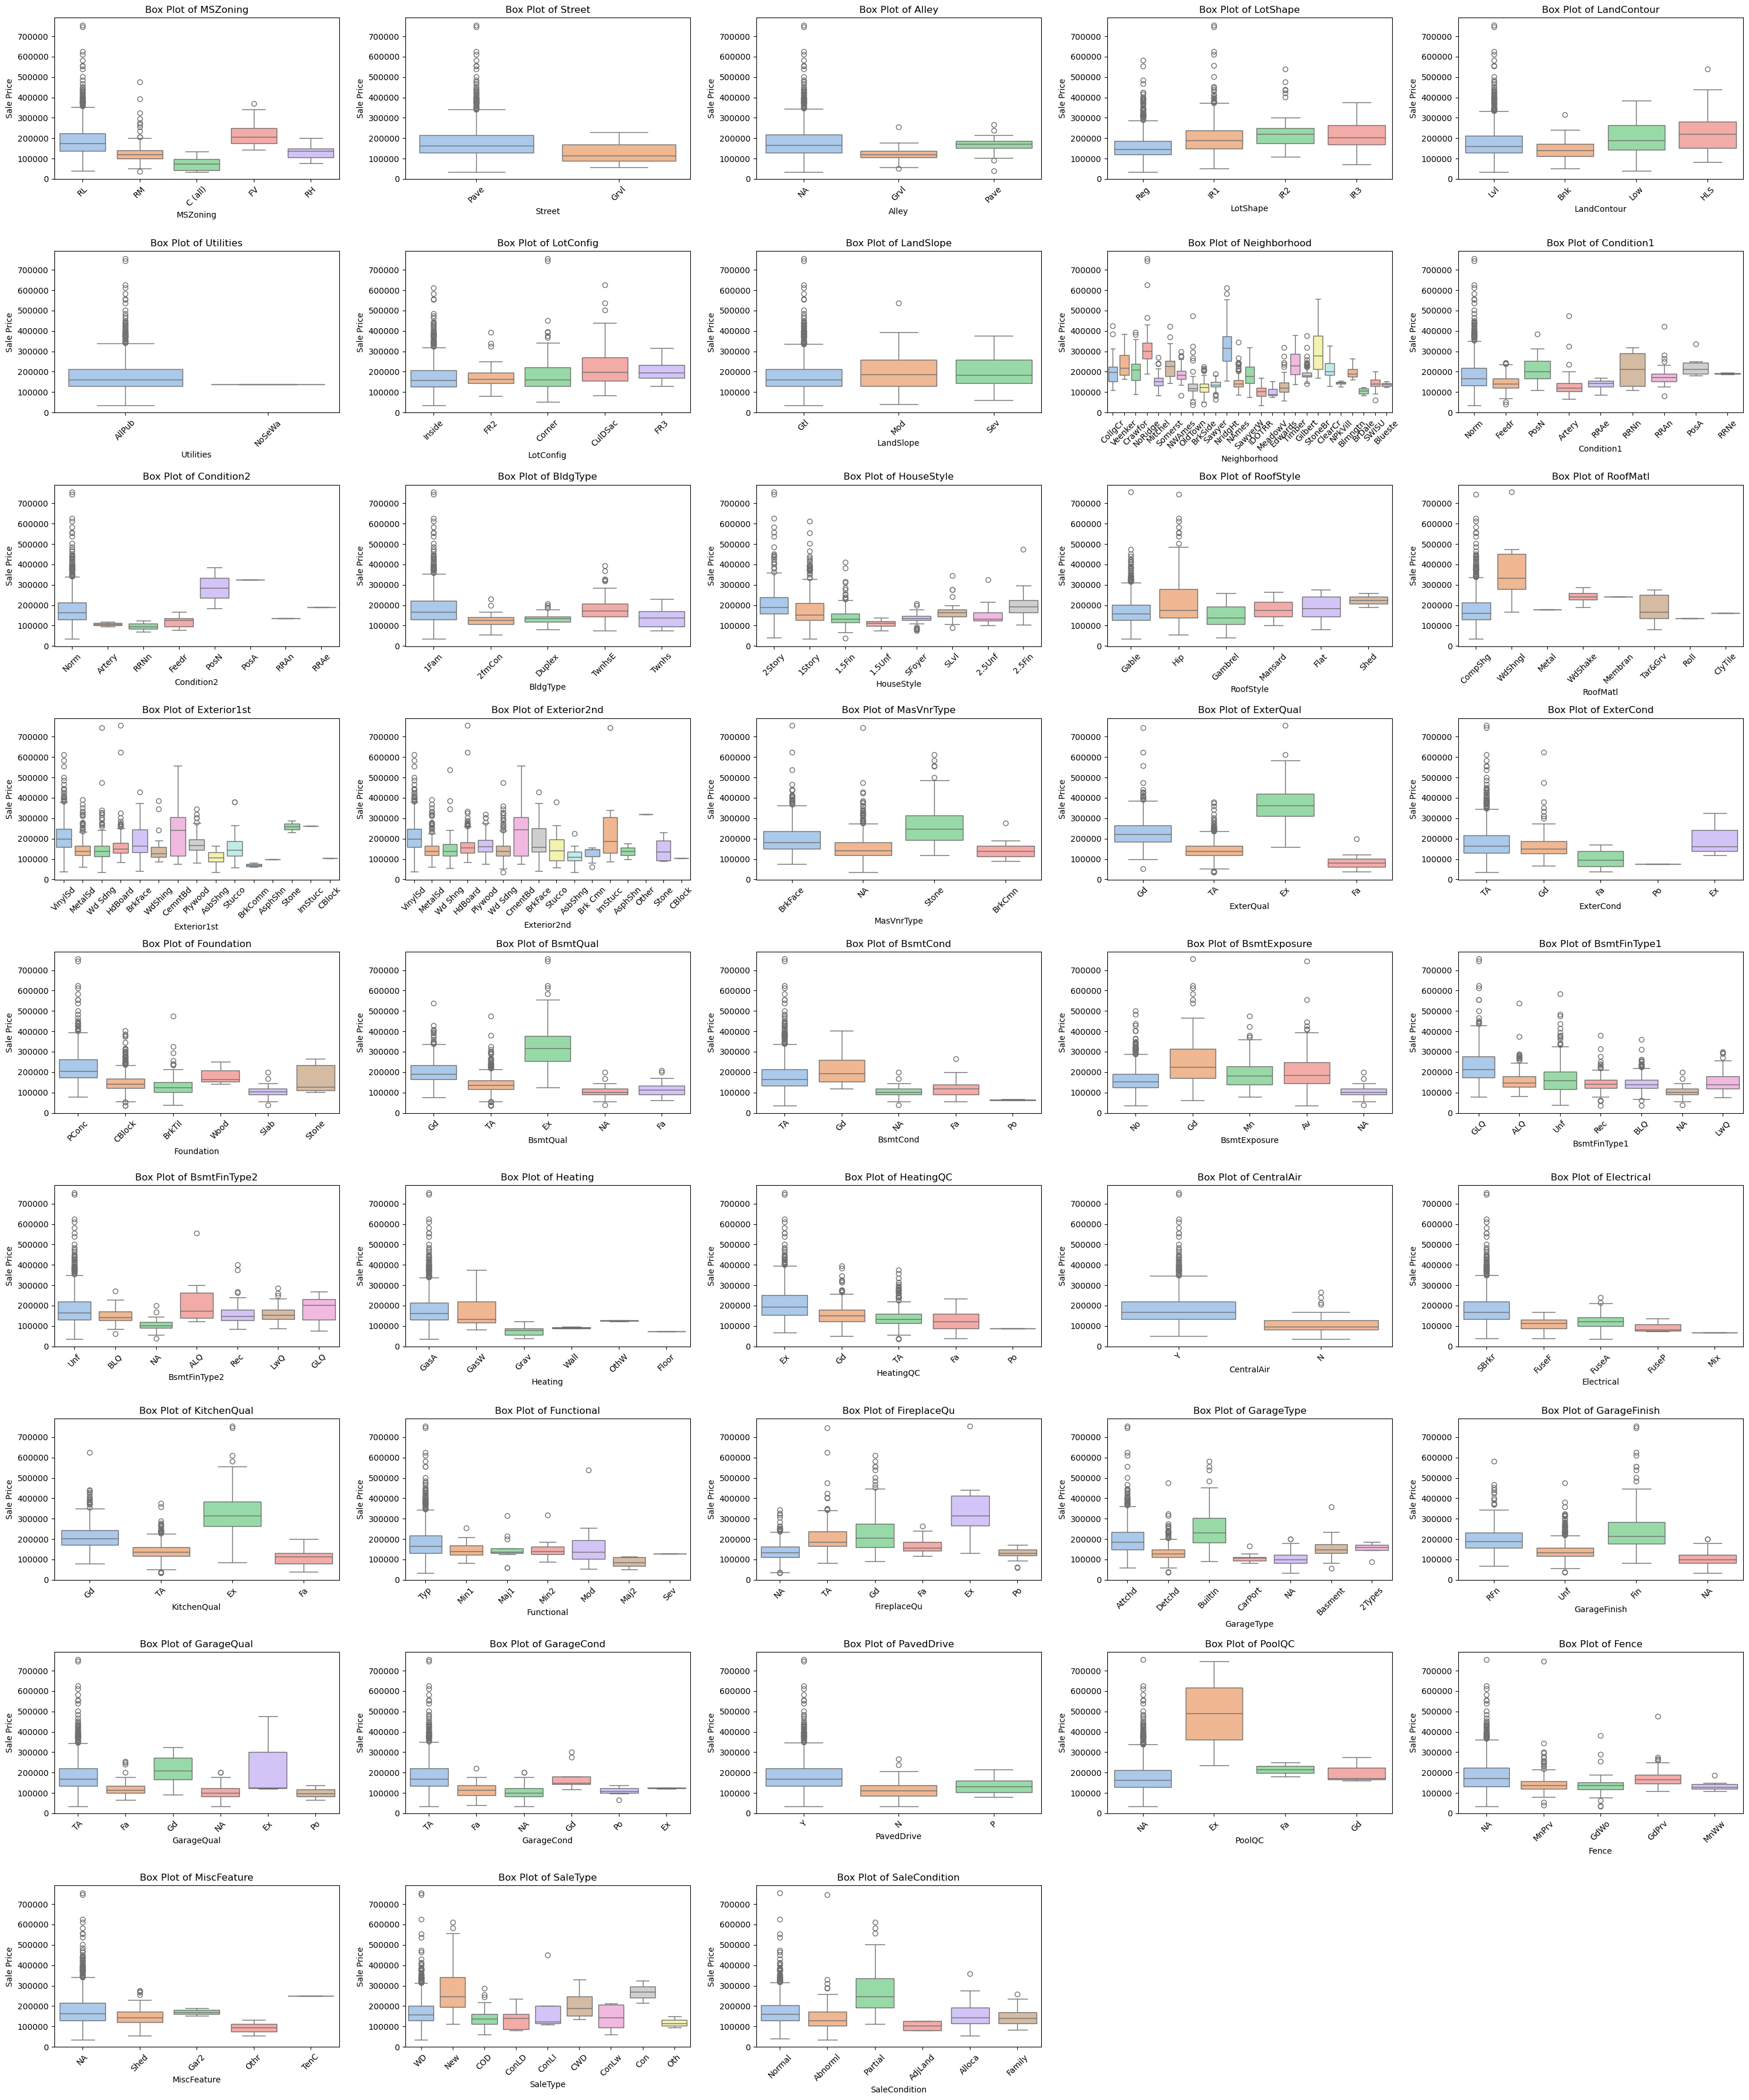

In [42]:
categorical_cols = train_data.select_dtypes(include=['object']).columns.tolist() 
plot_count_plots_grid(train_data, categorical_cols)

In [43]:
def plot_count_plots_grid_final(data, categorical_features, cols=2, color_palette='pastel'):
    """
    Create a grid of count plots for the specified categorical features in the dataset.
    
    Parameters:
        data: DataFrame - The input dataset.
        categorical_features: list - List of categorical features to plot.
        cols: int - Number of columns in the grid.
        color_palette: str - Color palette for the box plots.
    """
    num_features = len(categorical_features)
    rows = (num_features // cols) + (num_features % cols > 0)  # Calculate number of rows needed

    plt.figure(figsize=(4, rows*3))  # Adjust figure size based on the number of rows

    for i, feature in enumerate(categorical_features):
        plt.subplot(rows, cols, i + 1)  # Create a subplot grid
        sns.boxplot(data=data, x=feature, y='SalePrice', hue=feature,palette=color_palette,legend=False)
        plt.title(f'Box Plot of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Sale Price')
        plt.xticks(rotation=45)  # Rotate x labels for readability

    plt.tight_layout()
    plt.show()

#### ii. Finding Statistical Significance Between Categorical Features and Target Variable

In [44]:
def significant_categorical_features(data, target_variable, categorical_features, alpha=0.05):
    """
    Perform the Kruskal-Wallis H test to find significant categorical features related to the target variable.

    """
    significant_features = []
    insignificant_features = []

    for feature in categorical_features:
        # Prepare the data for the Kruskal-Wallis test
        groups = [data[target_variable][data[feature] == category] for category in data[feature].unique()]
        
        # Conduct the Kruskal-Wallis test
        h_statistic, p_value = stats.kruskal(*groups)
        
        # Check if the p-value is significant
        if p_value < alpha:
            significant_features.append((feature, p_value))
        else:
            insignificant_features.append((feature, p_value))

    
    # Create a DataFrame from the results
    return pd.DataFrame(significant_features, columns=['Feature', 'p-value']), pd.DataFrame(insignificant_features, columns=['Feature', 'p-value'])


In [45]:
# Get the categorical data types
categorical_cols = train_data.select_dtypes(include=['object']).columns.tolist() 
# Get significant features that influence SalePrice
significant_results, insignificant_results = significant_categorical_features(train_data, 'SalePrice', categorical_cols)


In [46]:
# show features with significant relationship to Sale Price
significant_results

,Feature,p-value
0,MSZoning,1.133928e-56
1,Alley,1.542329e-10
2,LotShape,1.054703e-32
3,LandContour,1.053607e-07
4,LotConfig,2.781977e-07
5,Neighborhood,4.643573e-166
6,Condition1,9.528968e-13
7,Condition2,1.335453e-02
8,BldgType,4.436885e-14
9,HouseStyle,2.618487e-36


In [47]:
# show the columns not significant to price
insignificant_results

,Feature,p-value
0,Street,0.081551
1,Utilities,0.528727
2,LandSlope,0.127853
3,PoolQC,0.109085


In [48]:
def kruskal_wallis_multiple_tests(data, categorical_vars, target_var):
    """
    Perform Kruskal-Wallis test on multiple categorical variables.

    Parameters:
    - data: DataFrame containing the data
    - categorical_vars: List of column names for the categorical variables
    - target_var: Column name for the target variable (e.g., sale prices)

    Returns:
    - results: Dictionary containing H-statistics, p-values, and eta-squared for each variable
    - non_significant: List of variables with p-values >= 0.05
    """

    results = {}
    non_significant = []

    for var in categorical_vars:
        # Filter unique groups based on the categorical variable
        groups = data[var].unique()
        
        # Prepare a list to store target variable values for each group
        group_data = [data[data[var] == group][target_var] for group in groups]
        
        # Perform the Kruskal-Wallis test
        H_statistic, p_value = kruskal(*group_data)
        
        # Calculate eta-squared
        k = len(groups)  # Number of groups
        n = len(data[target_var])  # Total number of observations
        eta_squared = (H_statistic - k + 1) / (n - k)
        
        # Store results
        results[var] = {
            'H_statistic': H_statistic,
            'p_value': p_value,
            'eta_squared': eta_squared
        }
        
        # Check non-significance
        if p_value >= 0.05:
            non_significant.append(var)
    
    return results, non_significant

In [49]:
# Specify categorical variables and the target variable
categorical_cols = train_data.select_dtypes(include=['object']).columns.tolist() 

# Perform the Kruskal-Wallis test on multiple categorical variables
results, non_significant_vars = kruskal_wallis_multiple_tests(train_data, categorical_cols, 'SalePrice')

NameError: name 'kruskal' is not defined

In [ ]:
import scipy
print(scipy.__version__) 

1.14.1


In [ ]:
# Filter results based on p-value >= 0.05
filtered_results = {var: stats for var, stats in results.items() if stats['p_value'] >= 0.05}

# Displaying filtered results
print("Filtered Results (p >= 0.05):")
for var, stats in filtered_results.items():
    print(f"{var}: H-statistic = {stats['H_statistic']}, p-value = {stats['p_value']}")

Filtered Results (p >= 0.05):
Street: H-statistic = 3.033717097319082, p-value = 0.08155099141205016
Utilities: H-statistic = 0.39683839501549895, p-value = 0.5287265748892203
LandSlope: H-statistic = 4.113744260064549, p-value = 0.12785325346753512
PoolQC: H-statistic = 6.052481363581347, p-value = 0.10908462341884893


In [ ]:
# get the Kruskal Walis and eta-squared results
insig_res = pd.DataFrame(filtered_results)

insig_res

,Street,Utilities,LandSlope,PoolQC
H_statistic,3.033717,0.396838,4.113744,6.052481
p_value,0.081551,0.528727,0.127853,0.109085
eta_squared,0.001405,-0.000417,0.001462,0.002112


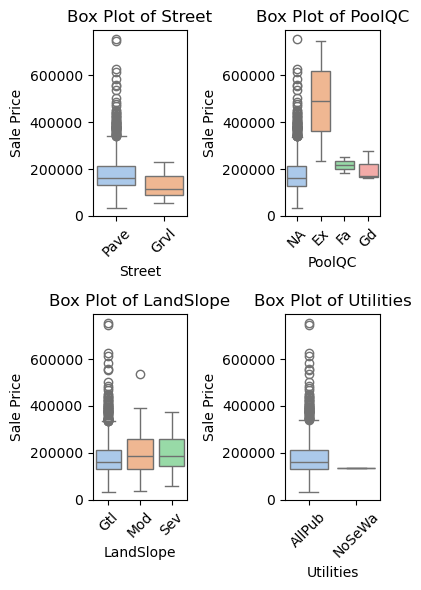

In [ ]:
cat_vars = ['Street','PoolQC','LandSlope','Utilities']
plot_count_plots_grid_final(train_data,cat_vars)

##### Insight:
- According to Kruskal-Wallis test: median Sale Prices do not have significant difference accross different categories of Street, Utilities, LandSlope, and PoolQC.
- However, the box plots of these variables on Sale Prices suggested there were outliers concentrated in one of the groups in the variables. These outliers could deviate the true significant relationship between Sale Price and the variables.
- Therefore, it would be more ideal to perform outlier handling techniques than remove these variables.

#### B. Numerical Data

#### 1. Sale Price Distribution (Target Variable)

Initial analysis
- Sale price distribution with histogram

Confirmatory analysis
- D'Agostino’s K-squared Test  
reason: it combines information on skewness (asymmetry of the distribution) and kurtosis (tailedness of the distribution)

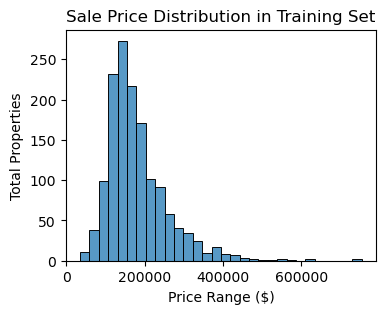

In [ ]:
# show distribution of Sale Price
plt.figure(figsize=(4,3))

# Plot result
sns.histplot(data=train_data,x='SalePrice',bins = 30)
plt.title("Sale Price Distribution in Training Set")
plt.ylabel("Total Properties")
plt.xlabel("Price Range ($)")
plt.show()

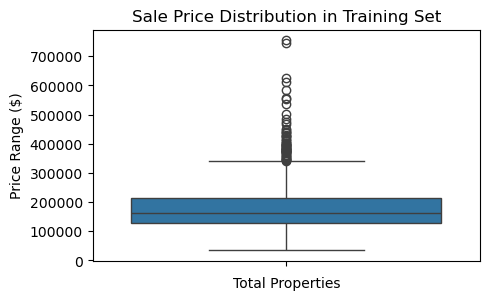

In [ ]:
# show distribution of Sale Price
plt.figure(figsize=(5,3))

# Plot result
sns.boxplot(data=train_data,y='SalePrice')
plt.title("Sale Price Distribution in Training Set")
plt.ylabel("Price Range ($)")
plt.xlabel("Total Properties")
plt.show()

##### Insight:
- Histogram showed right-skewed distribution, meanwhile, the box plot diagram indicated numerous outliers beyond the upper bound of whisker plot (around $350K).

In [ ]:
from scipy import stats

# Calculate D'Agostino's K-squared test
statistic, p_value = stats.normaltest(train_data['SalePrice'])

print(f'Statistic: {statistic}, p-value: {p_value}')

Statistic: 608.4001305716492, p-value: 7.719519200609547e-133


In [ ]:
# perform normality test to confirm whether it follows normal distribution or not
# Calculate D'Agostino's K-squared test
# statistic, p_value = stats.normaltest(train_data['SalePrice'])
statistic, p_value = stats.normaltest(train_data['SalePrice'])

print(f'Statistic: {statistic}, p-value: {p_value}')

# Interpret the result
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis: the data is not normally distributed.")
else:
    print("Fail to reject the null hypothesis: the data appears to be normally distributed.")

Statistic: 608.4001305716492, p-value: 7.719519200609547e-133
Reject the null hypothesis: the data is not normally distributed.


##### Insight:
- Normality test suggested that the data had no normal distribution. Therefore, it's recommended to transform with log function to compress the outlier values.

In [ ]:
# make a new feature to compare data distribution
train_data['log_sale_price'] = np.log10(train_data['SalePrice'])

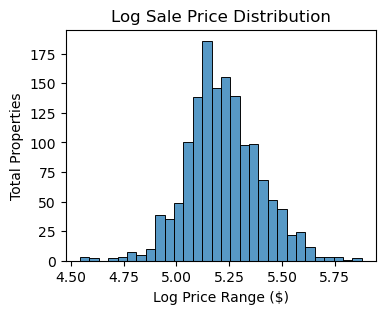

In [ ]:
# make histogram
plt.figure(figsize=(4,3))

# Plot result
# sns.histplot(data=train_data,x='SalePrice',bins = 30)
sns.histplot(data=train_data,x='log_sale_price',bins = 30)

plt.title("Log Sale Price Distribution")
plt.ylabel("Total Properties")
plt.xlabel("Log Price Range ($)")
plt.show()

##### Insight:
- Since SalePrice is not normally distributed, it's better to use non-linear models or transform it with with log or square root functions.

In [ ]:
statistic, p_value = stats.normaltest(train_data['log_sale_price'])

print(f'Statistic: {statistic}, p-value: {p_value}')

# Interpret the result
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis: the data is not normally distributed.")
else:
    print("Fail to reject the null hypothesis: the data appears to be normally distributed.")

Statistic: 25.32847715590951, p-value: 3.162212623893183e-06
Reject the null hypothesis: the data is not normally distributed.


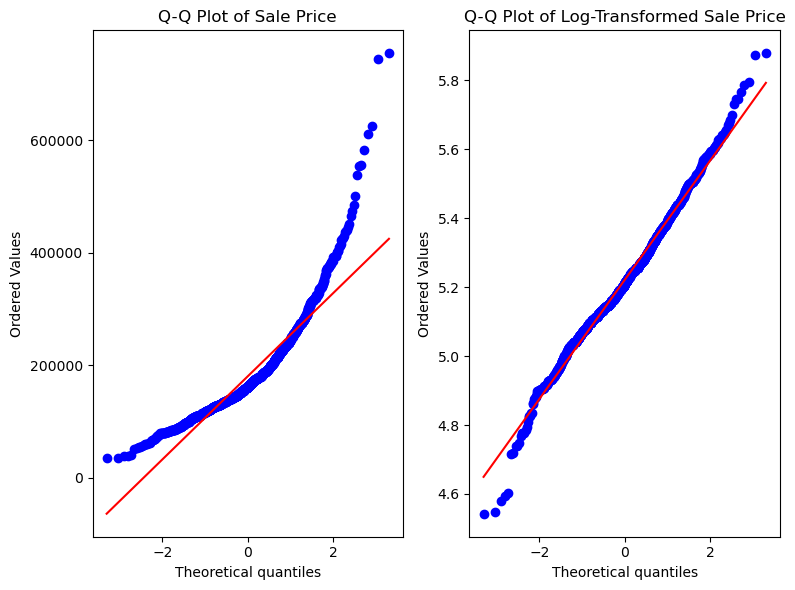

In [ ]:
# Sample data: replace this with your actual dataset
data_original = train_data['SalePrice']  # Original skewed data
data_log_transformed = train_data['log_sale_price']  # Log transformation

# Q-Q plot for original data
plt.figure(figsize=(8, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
stats.probplot(data_original, dist="norm", plot=plt)
plt.title('Q-Q Plot of Sale Price')

# Q-Q plot for log-transformed data
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
stats.probplot(data_log_transformed, dist="norm", plot=plt)
plt.title('Q-Q Plot of Log-Transformed Sale Price')

plt.tight_layout()
plt.show()

In [ ]:
train_data.SalePrice.describe()

count      1449.000000
mean     180544.563147
std       79319.721026
min       34900.000000
25%      129900.000000
50%      162000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [ ]:
train_data.log_sale_price.describe()

count    1449.000000
mean        5.221053
std         0.173506
min         4.542825
25%         5.113609
50%         5.209515
75%         5.330414
max         5.877947
Name: log_sale_price, dtype: float64

##### Insight:
- Log base 10 transformation improved the normality of the sale price distribution; based on QQ Plot.
- Even though log base 10 transformation sale price rejected null-hypothesis of Kruskal-Wallis test, QQ Plot suggested most of the data followed normal distribution.

#### 2. Correlation study

In [ ]:
# Drop irrelevant columns
df_corr = train_data.drop(columns=['Id']) # Assuming 'Id' is not a useful feature

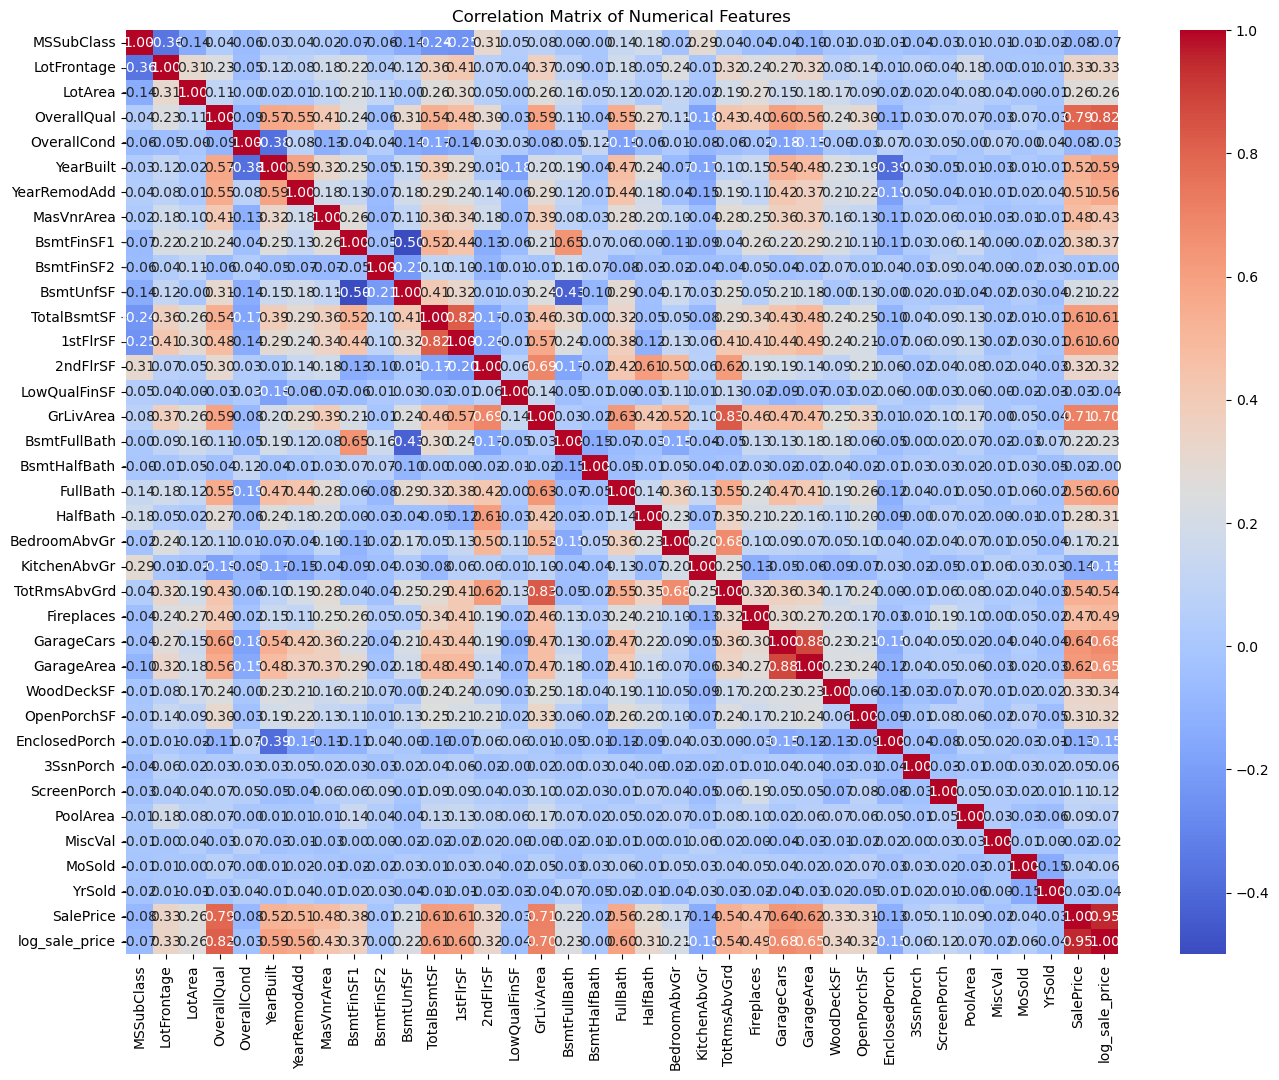

In [ ]:
# 2. Correlation Heatmap (Numerical Features Only)
# Select numerical columns only
numerical_features = df_corr.select_dtypes(include=[np.number])
# Compute correlation matrix
correlation_matrix = numerical_features.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f",
cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

Correlation of features with SalePrice:
 SalePrice         1.000000
log_sale_price    0.948392
OverallQual       0.789881
GrLivArea         0.710319
GarageCars        0.639235
GarageArea        0.621918
TotalBsmtSF       0.614420
1stFlrSF          0.606678
FullBath          0.562492
TotRmsAbvGrd      0.536419
YearBuilt         0.522918
YearRemodAdd      0.507138
MasVnrArea        0.476985
Fireplaces        0.468764
BsmtFinSF1        0.383398
LotFrontage       0.333010
WoodDeckSF        0.325569
2ndFlrSF          0.323842
OpenPorchSF       0.312097
HalfBath          0.283257
LotArea           0.264787
BsmtFullBath      0.224354
BsmtUnfSF         0.214098
BedroomAbvGr      0.171898
ScreenPorch       0.113362
PoolArea          0.093227
3SsnPorch         0.045379
MoSold            0.044118
BsmtFinSF2       -0.012762
BsmtHalfBath     -0.015788
MiscVal          -0.020885
LowQualFinSF     -0.025171
YrSold           -0.026865
OverallCond      -0.075898
MSSubClass       -0.082054
EnclosedPorch 

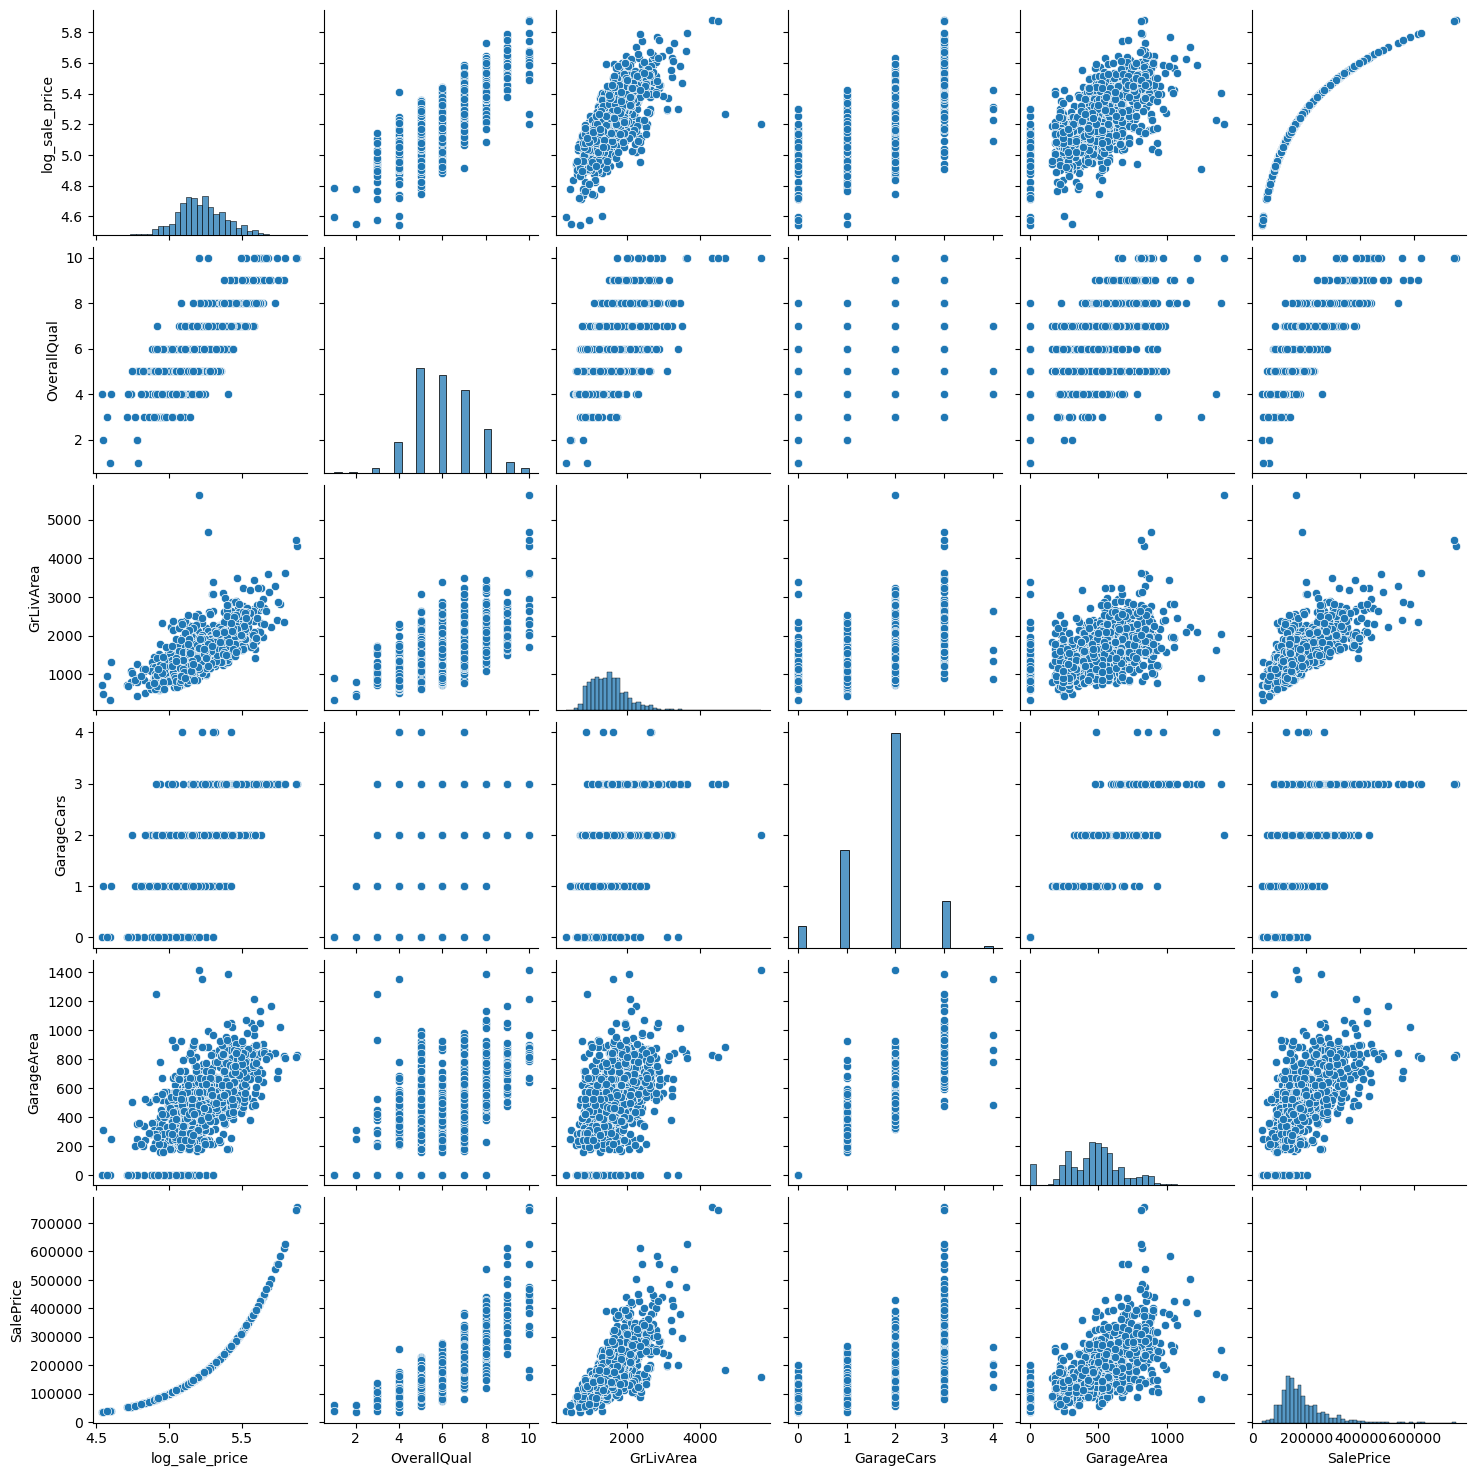

In [ ]:
# 3. SalePrice Correlation Analysis
# Sort features based on correlation with SalePrice
corr_with_price = correlation_matrix['SalePrice'].sort_values(ascending=False)
print("Correlation of features with SalePrice:\n", corr_with_price)

# 4. Pairplot with Top Correlated Features
# Select top 5 features most correlated with SalePrice (excludingSalePrice itself
top_features = corr_with_price.index[1:6]
sns.pairplot(df_corr[top_features.to_list() + ['SalePrice']])
plt.show()
# 5. Variance Inf

In [ ]:
# 5. Variance Inflation Factor (VIF) to Check Multicollinearity
# Drop SalePrice as it's the target variable and not used for predicting other features
X = numerical_features.drop(columns=['SalePrice'])
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in
range(X.shape[1])]
print("Variance Inflation Factor (VIF) for features:\n", vif_data)

/Users/catherinemulyadi/anaconda3/envs/new_base/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Variance Inflation Factor (VIF) for features:
            Feature           VIF
0       MSSubClass  4.748113e+00
1      LotFrontage  1.740819e+01
2          LotArea  2.671564e+00
3      OverallQual  7.926209e+01
4      OverallCond  4.436161e+01
5        YearBuilt  1.887345e+04
6     YearRemodAdd  2.082936e+04
7       MasVnrArea  1.852908e+00
8       BsmtFinSF1           inf
9       BsmtFinSF2           inf
10       BsmtUnfSF           inf
11     TotalBsmtSF           inf
12        1stFlrSF           inf
13        2ndFlrSF           inf
14    LowQualFinSF           inf
15       GrLivArea           inf
16    BsmtFullBath  3.744670e+00
17    BsmtHalfBath  1.219078e+00
18        FullBath  2.646137e+01
19        HalfBath  3.409523e+00
20    BedroomAbvGr  3.085642e+01
21    KitchenAbvGr  3.777980e+01
22    TotRmsAbvGrd  8.351429e+01
23      Fireplaces  3.068730e+00
24      GarageCars  3.670503e+01
25      GarageArea  3.061424e+01
26      WoodDeckSF  1.912705e+00
27     OpenPorchSF  1.812664e

Number of outliers in SalePrice: 21


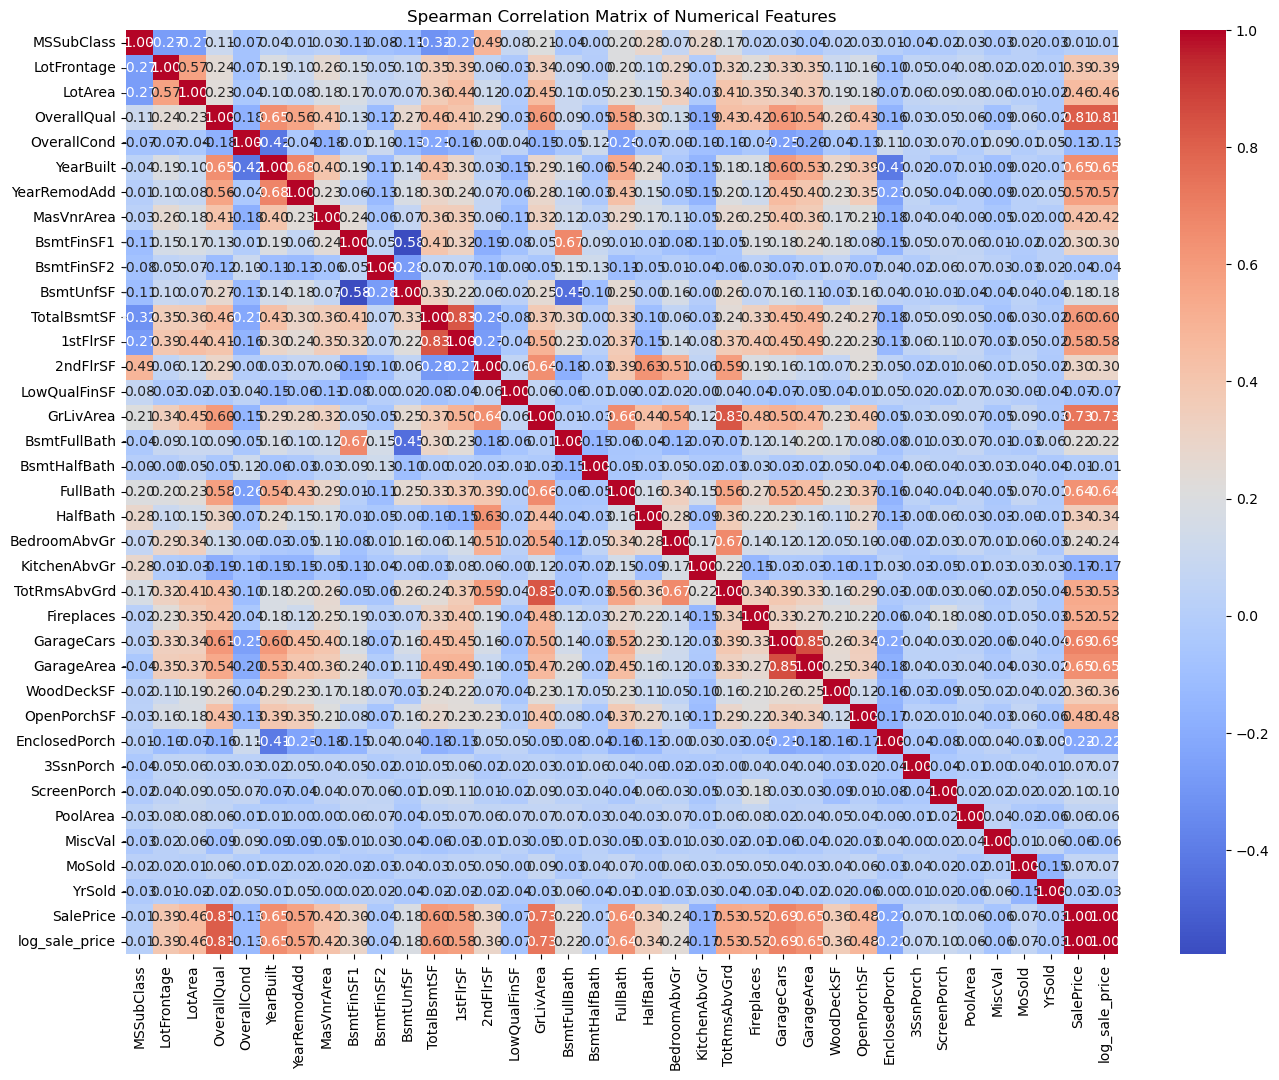

Correlation of features with SalePrice:
 log_sale_price    1.000000
SalePrice         1.000000
OverallQual       0.809033
GrLivArea         0.731119
GarageCars        0.689511
YearBuilt         0.652185
GarageArea        0.648338
FullBath          0.635554
TotalBsmtSF       0.602667
1stFlrSF          0.576396
YearRemodAdd      0.570435
TotRmsAbvGrd      0.533456
Fireplaces        0.520826
OpenPorchSF       0.478253
LotArea           0.457090
MasVnrArea        0.420339
LotFrontage       0.390668
WoodDeckSF        0.356846
HalfBath          0.342633
BsmtFinSF1        0.299438
2ndFlrSF          0.295107
BedroomAbvGr      0.237334
BsmtFullBath      0.222240
BsmtUnfSF         0.183749
ScreenPorch       0.102607
MoSold            0.069040
3SsnPorch         0.066578
PoolArea          0.059109
MSSubClass        0.009576
BsmtHalfBath     -0.010203
YrSold           -0.029767
BsmtFinSF2       -0.039725
MiscVal          -0.061704
LowQualFinSF     -0.067193
OverallCond      -0.126050
KitchenAbvGr  

In [ ]:
# Calculate Z-scores
z_scores = np.abs(zscore(df_corr['SalePrice']))
outliers = df_corr[z_scores > 3] # Assume Z-score > 3 as an outlier
print(f"Number of outliers in SalePrice: {len(outliers)}")
# 7. Non-linear Correlation Check (Spearman)
# Compute Spearman correlation for non-linear relationships
spearman_corr = numerical_features.corr(method='spearman')
plt.figure(figsize=(16, 12))
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Spearman Correlation Matrix of Numerical Features')
plt.show()
corr_with_price2 =spearman_corr['SalePrice'].sort_values(ascending=False)
print("Correlation of features with SalePrice:\n", corr_with_price2)
# Combine Spearman and Pearson correlations into a single DataFrame
correlation_table = pd.DataFrame({
'Feature': corr_with_price.index,
'Spearman Correlation': corr_with_price2.values,
'Pearson Correlation': corr_with_price.values
}).sort_values(by='Spearman Correlation', ascending=False)
# Display the table
print(correlation_table)

In [ ]:
# combine features
# Load dataset
df = pd.read_csv(file_path)
# Drop 'Id' column as it's likely irrelevant to prediction
df = df.drop(columns=['Id'])
# Data Cleaning: Fill missing values
for column in df.columns:
    if df[column].dtype == 'object':
        df[column].fillna(df[column].mode()[0], inplace=True)
    else:
        df[column].fillna(df[column].median(), inplace=True)
# Step 1: Combine Related Features to Reduce Multicollinearity
df['TotalHouseSF'] = df['GrLivArea'] + df['TotalBsmtSF'] +df['1stFlrSF']
df['TotalPorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch'] + df['WoodDeckSF']
# Drop original features that have been combined
combined_df = df.drop(columns=['GrLivArea', 'TotalBsmtSF', '1stFlrSF',
'OpenPorchSF', 'EnclosedPorch',
'3SsnPorch',
'ScreenPorch', 'WoodDeckSF'])
# Step 2: Encode Selected Categorical Features to Limit Dimensionality
categorical_features = ['MSZoning', 'Neighborhood', 'Condition1',
'BldgType', 'HouseStyle']
numeric_features =combined_df.select_dtypes(include=[np.number]).drop(columns=['SalePrice']).columns
# Define a preprocessing pipeline
preprocessor = ColumnTransformer(
transformers=[
('num', StandardScaler(), numeric_features),
('cat', OneHotEncoder(drop='first'), categorical_features)
],
remainder='drop'
)
# Step 3: Ridge Regression for Multicollinearity
ridge_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
('ridge', Ridge(alpha=1.0))])
# Split the data for training and testing
X = combined_df.drop(columns=['SalePrice'])
y = combined_df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.2, random_state=42)
# Fit Ridge regression model on the training data
ridge_pipeline.fit(X_train, y_train)
# Extract processed feature names after one-hot encoding and scaling
encoded_feature_names = (
ridge_pipeline.named_steps['preprocessor']
.transformers_[1][1] # Access OneHotEncoder
.get_feature_names_out(categorical_features)
)
all_feature_names = list(numeric_features) +list(encoded_feature_names)
# Step 4: Calculate VIF to verify reduced multicollinearity
# Get the transformed training data and calculate VIF
X_train_transformed = ridge_pipeline.named_steps['preprocessor'].transform(X_train)
vif_data = pd.DataFrame()
vif_data["Feature"] = all_feature_names
vif_data["VIF"] = [variance_inflation_factor(X_train_transformed, i)
for i in range(X_train_transformed.shape[1])]
print("VIF after combining features and Ridge regularization:\n"
,
vif_data)
# Calculate Spearman and Pearson Correlations
# Prepare final DataFrame with transformed features for correlation analysis
final_encoded_df = pd.DataFrame(X_train_transformed, columns=all_feature_names)
final_encoded_df['SalePrice'] = y_train.values

# Spearman correlation
spearman_corr = final_encoded_df.corr(method='spearman')['SalePrice'].sort_values(ascending=False)

# Pearson correlation
pearson_corr = final_encoded_df.corr(method='pearson')['SalePrice'].sort_values(ascending=False)

# Check lengths
print(f"Spearman Length: {len(spearman_corr)}; Pearson Length: {len(pearson_corr)}")

# Combine Spearman and Pearson correlations into a single DataFrame
correlation_table = pd.DataFrame({
    'Feature': spearman_corr.index,
    'Spearman Correlation': spearman_corr.values,
    'Pearson Correlation': pearson_corr.values
}).sort_values(by='Spearman Correlation', ascending=False)

# Display the table
print(correlation_table)

NameError: name 'pd' is not defined

In [ ]:
# Assuming the rest of your code is correctly set up up to this point...

# Calculate Spearman and Pearson Correlations
# Prepare final DataFrame with transformed features for correlation analysis
final_encoded_df = pd.DataFrame(X_train_transformed, columns=all_feature_names)
final_encoded_df['SalePrice'] = y_train.values

# Spearman correlation
spearman_corr = final_encoded_df.corr(method='spearman')['SalePrice'].sort_values(ascending=False)

# Pearson correlation
pearson_corr = final_encoded_df.corr(method='pearson')['SalePrice'].sort_values(ascending=False)

# Check lengths
print(f"Spearman Length: {len(spearman_corr)}; Pearson Length: {len(pearson_corr)}")

# Combine Spearman and Pearson correlations into a single DataFrame
correlation_table = pd.DataFrame({
    'Feature': spearman_corr.index,
    'Spearman Correlation': spearman_corr.values,
    'Pearson Correlation': pearson_corr.values
}).sort_values(by='Spearman Correlation', ascending=False)

# Display the table
print(correlation_table)

Spearman Length: 78; Pearson Length: 78
                 Feature  Spearman Correlation  Pearson Correlation
0              SalePrice              1.000000             1.000000
1            OverallQual              0.801016             0.785555
2           TotalHouseSF              0.772681             0.740471
3             GarageCars              0.686763             0.640991
4              YearBuilt              0.643216             0.624139
..                   ...                   ...                  ...
73  Neighborhood_BrkSide             -0.187531            -0.152411
74    Neighborhood_NAmes             -0.199958            -0.182749
75  Neighborhood_Edwards             -0.245450            -0.188711
76  Neighborhood_OldTown             -0.245731            -0.196642
77           MSZoning_RM             -0.368936            -0.279680

[78 rows x 3 columns]


### Feature Engineering

### Modeling
- Model selection: Random Forest, XGBoost, Linear Regression, and Log-Lin Regression

#### Experiment 1: comparison between log-transformed and linear regression analysis

#### Experiment 2: without capping outliers

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_data_cleaned, target_var, test_size=0.2, random_state=42)

rf_model = XGBRegressor(
    n_estimators=3333,
    learning_rate=0.01,
    max_depth=7,
    min_child_weight=4,
    gamma=0,
    subsample=0.751,
    colsample_bytree=0.705,
    reg_alpha=0.3,
    reg_lambda=0.15
)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

#### Experiment 3: with capping outliers